Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Bowen Zhang"
COLLABORATORS = ""

---

## Dimensionality analysis of Stock Prices / Notebook 2

In this notebook we will study the dimensionality of stock price sequences, and show that they lie between the 1D of smooth functions and 2D of rapidly varying functions.

The mathematicians Manuel Mandelbrot and Richard Hudson wrote a book titled [The Misbehavior of Markets: A Fractal View of Financial Turbulence](https://www.amazon.com/gp/product/0465043577?ie=UTF8&tag=trivisonno-20&linkCode=as2&camp=1789&creative=9325&creativeASIN=0465043577).  In this book they demonstrate that financial sequences have a fractal dimension that is higher than one. In other words, the changes in stock prices are more similar to random walk, than to a smooth differentiable curve.

In this notebook we will estimate the fractal dimension of sequences corresponding to the log of the price of a stock. We will do the same for some other, non-random sequences.

We will use the [Box Counting](https://en.wikipedia.org/wiki/Box_counting) method to estimate the dimension.

### Box Counting
For the sake of simplicity, lets start with a simple smooth curve corresponding to $sin(x)$.
Intuitively speaking, the dimension of this curve should be 1. Lets see how we measure that using box-counting.

The idea is simple: we split the 2D plane into smaller and smaller rectangles and count the number of rectangles that touch the curve.  The gridlines in the figure below partition the figure into $16 \times 16 = 256$ rectangles. The yellow shading corresponds the partition of the figure into $8 \times 8$ rectangles. The green corresponds to the partition into $16\times 16$ (which is the same as the grid), The blue and the red correspond to partitions into $32\times32$ and $64 \times 64$ respectively. You can see that as theboxes get smaller their number increases. 

![Sinusoid](figs/Sinusoid.BoxCount.png)

The dimension is defined by the relation between the size of the cubes and the number of rectangle that touch the curve. More precisly, we say that the size of a rectangle in a $n \times n$ partition is $\epsilon=1/n$. We denote by $N(\epsilon)$ the number of rectangles of size $\epsilon$ that touch the curve. Then if $d$ is the dimension, the relationship between $N(\epsilon)$ and $\epsilon$ is 
$$
N(\epsilon) = \frac{C}{\epsilon^d}
$$
For some constant $C$

Taking $\log$s of both side we get 
$$
(1)\;\;\;\;\;\;\;\;\;\;\;\;\log N(\epsilon) = \log C + d \log \frac{1}{\epsilon}
$$

We can use this equation to estimate $d$ as follows: let $\epsilon_2 \gg \epsilon_1$ be two sizes that are far apart (say $\epsilon_1=1/4$ and $\epsilon_2=1/1024$), and let $N(\epsilon_1),N(\epsilon_2)$ be the corresponding box counts. Then by taking the difference between Equation (1) for the two sizes we get the estimate
$$
    d \approx \frac{\log N(\epsilon_1) - \log N(\epsilon_2)}{\log \epsilon_2- \log \epsilon_1}
$$

Note that this is an estimate, it depends on the particular values of $\epsilon_1$ and $\epsilon_2$. We can refer to it as the "dimension" if we get the same number for any choice of the two sizes (as well as other details sich as the extent of the function.

Here are similar figures for the seque
![AMZN](figs/AMZN.BoxCount.png)

![IBM](figs/IBM.BoxCount.png)		

### Download the data files
You might have made a mistake in producing the file `data/SP500.csv`. To avoid propagating this mistake, we download the correct file from S3

In [2]:
!wget https://mas-dse-open.s3.amazonaws.com/Stocks/data.tgz
!tar xzvf data.tgz

--2018-06-15 04:45:02--  https://mas-dse-open.s3.amazonaws.com/Stocks/data.tgz
Resolving mas-dse-open.s3.amazonaws.com (mas-dse-open.s3.amazonaws.com)... 52.218.128.122
Connecting to mas-dse-open.s3.amazonaws.com (mas-dse-open.s3.amazonaws.com)|52.218.128.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52006823 (50M) [application/x-tar]
Saving to: ‘data.tgz.4’

data.tgz.4          100%[===================>]  49.60M  20.4MB/s    in 2.4s    

2018-06-15 04:45:04 (20.4 MB/s) - ‘data.tgz.4’ saved [52006823/52006823]

data/
data/PCA.pickle
data/SP500.csv
data/tickerInfo.tsv


### Notebook Setup

In [3]:
#import findspark
#findspark.init()
from pyspark import SparkContext

#sc.stop()
sc = SparkContext(master="local[3]")

from pyspark.sql import *
sqlContext = SQLContext(sc)

%pylab inline

import numpy as np


Populating the interactive namespace from numpy and matplotlib


In [4]:
df=sqlContext.read.csv('data/SP500.csv',header='true',inferSchema='true')
df.count()

13422

In [5]:
def get_seq(ticker):
    if ticker[0].isdigit():
        key='test/%s_P'%ticker
    else:
        key='train/%s_P'%ticker
    L=df.select(key).collect()
    L=[x[key] for x in L if not x[key] is None]
    return L

In [6]:
def calc_splitpoints(R,count):
    return arange(R[0],R[1],(R[1]-R[0])/(count*1.00001))

### Exercise
Your task in this exercise is to compute the dimensionality of a stock price sequence. The sequence contains the log prices of a single stock over the course of 30+ years. We shall use the box counting approach described above to deduce the dimenionality. Specifically, you are required to do the following:

* Take the 2D region that contains the stock price sequence. The X-axis represents the ***day*** and the Y-axis represents the ***log of the stock price*** on that day. Divide this 2D space into rectangles of equal sizes such that the 2D space is divided into a grid of $N \times N$ rectangles where $N \in \{1,2,4,8,16,32,64,128,256,512,1024,2048\}$ 
 * For each value of $N$, keep track of the number of boxes that the curve passes through. You can do this by using the intuition that the y-axis (log of prices) is a function of the x-axis (days). Assume, that the X-axis needs to be divided into $N$ parts. Then we can find $N+1$ points on the X-axis that divides it into $N$ parts of equal length $l$. Each consecutive pair of points $[x_{k}, x_{k+1}]$ defines a range on the X-axis that will contain $N$ rectangles of height $h$ stacked on top of each other and spanning over the range $[y_{min}, y_{max}]$ where $y_{min}$ is the minumum stock price and $y_{max}$ is the maximum stock price over the entire span of time.
 * Within the set of $N$ rectangles in the range $R = [x_{k}, x{k+1}]$, the $y$ values (log prices) will lie in a continuous interval $y_{min}^R, y_{max}^R$ where $y_{min}^R$ and $y_{max}^R$ are the lower and upper limits of the stock price sequence in the range of $R$. By knowing this interval and the height of each rectangle, you can compute the number of rectangles that the sequence passes through in the range $R$. Repeating the process for each $ R = [x_{k}, x{k+1}] $ where $k \in {1,2,3...N}$ gives us the total number of rectangles that the curve passes through.
* To find the dimensionality of the sequence, use the formula given above and the $\epsilon_1 = \frac{1}{16}$, $\epsilon_2 = \frac{1}{2048}$

Output Requirements: You are expected to return the following values in the order given below
1. ***box_counts***: A 2D numpy array that contains the number of boxes the sequence passed through for each value $N \in \{1,2,4,8,16,32,64,128,256,512,1024,2048\}$. The first column in the array is the value of $N$ and the second is the count of number of rectangles that the sequence passed through for that value of $N$. An example is shown below:
```
     [[1.0 2.0000e+00]
      [2.0 5.0000e+00] 
      [4.0 1.7000e+01] 
      [8.0 4.4000e+01] 
      [16.0 9.2000e+01] 
      [32.0 1.8700e+02] 
      [64.0 3.7800e+02] 
      [128.0 7.5800e+02] 
      [256.0 1.5120e+03] 
      [512.0 2.9990e+03] 
      [1024.0 5.8950e+03] 
      [2048.0 1.1252e+04]]
```

2. ***dims***: A variable that contains the dimensionality of the sequence using the calculation given above
3. ***covers***: A dictionary where the keys are is $N \in \{1,2,4,8,16,32,64,128,256,512,1024,2048\}$ and the value is an array containing tuples of the form ($x_{k}, x_{k+1}, flooRec_{x_k,x_{k+1}}(y_{min}^R), ceilRec_{x_k,x_{k+1}}(y_{max}^R$)). Here, $floorRec$ and $ceilRec$ are defined as:
$$ floorRec_{x_k,x_{k+1}}(y) = \text{Floor of the rectangle that contains the point y, in the X-axis range }[x_{k}, x_{k+1}]$$
$$ ceilRec_{x_k,x_{k+1}}(y) = \text{Ceiling of the rectangle that contains the point y, in the X-axis range }[x_{k}, x_{k+1}]$$
For example if the the range of x values is $[0, 8]$ and $N=4$, then we would have 4 intervals on the x-axis: $[0, 2], [2, 4], [4, 6], [6, 8]$. Assuming the y values lie in the range $[0, 6]$, the corresponding 4 intervals on the y-axis would be $[0, 1.5], [1.5, 3.0], [3.0, 4.5], [4.5, 6.0]$. The $y_{min}^R, y_{max}^R$ represent the minimum and maximum values taken by the stock price sequence in each of the 4 intervals. Assuming these min and max values are $[3.5, 4.6], [2.5, 3.7], [1.2, 5.5], [5.2, 5.6]$ respectively, the key value pair in ***covers*** for $N=4$ would be:

``` 
{4: [(0, 2, 3.0, 6.0), (2, 4, 1.5, 4.5), (4, 6, 0.0, 6.0), (6, 8, 4.5, 6.0)]} # Notice there are N entries in the value for key N

```

***Hint:*** You might find the <font color="blue">calc_splitpoints</font> useful to split the X-axis into $N$ segments

In [7]:
def Box_count(LL,ticker):
    # YOUR CODE HERE
    N = []
    covers = {}
    y_min = min(LL)
    y_max = max(LL)
    for i in [1,2,4,8,16,32,64,128,256,512,1024,2048]:
        covers[i] = []
        numBox = 0
        y_R = calc_splitpoints([y_min, y_max], i)
        x_R = calc_splitpoints([0, len(LL)], i)
        #print('i = ' + str(i))
        for j in range(i):
            y_min_R = min(LL[int(x_R[j]):int(x_R[j+1])])#ceil, floor
            y_max_R = max(LL[int(x_R[j]):int(x_R[j+1])])
            floorRec = y_min_R - min([y for y in (y_min_R - y_R) if y >= 0])
            #print('index = ' + str(np.argmin([y for y in (y_min_R - y_R) if y >= 0])) + ' floorRec = ' + str(floorRec))
            
            ceilRec = y_max_R - max([y for y in (y_max_R - y_R) if y <= 10e-5])
            #print('index = ' + str(np.argmax([y for y in (y_max_R - y_R) if y <= 10e-5])) + ' ceilRec = ' + str(ceilRec))
            
            #if (ceilRec == floorRec):
            #    print('LL_R: ' + str(LL[int(x_R[j]):int(x_R[j+1])]))
            #    print('y_min_R: ' + str(y_min_R) + ' y_max_R :' + str(y_max_R) + 'ceil/floorRec: ' + str(ceilRec))
            numBox += (ceilRec - floorRec) / (y_R[1] - y_R[0])
            covers[i].append((int(x_R[j]), int(x_R[j+1]), floorRec, ceilRec))
        N.append([i, numBox])
        if (i == 16):
            numBox_16 = numBox
        elif (i == 2048):
            numBox_2048 = numBox
        else:
            continue
    N = np.array(N)
    dim = (log(numBox_16) - log(numBox_2048)) / (log(16) - log(2048))
    return N, dim, covers

In [8]:
def plot_box_count(N):
    plot(log(N[:,0]),log(N[:,1]));
    title('Box Count Graph for '+ticker)
    xlabel('log 1/epsilon')
    ylabel('log N');
    grid()

In [9]:
def analyze_sequence(L,ticker):
    figure(figsize=(13,5))
    subplot(121)
    LL=log(L)
    plot(LL)
    title('time series for '+ticker)
    xlabel('days')
    ylabel('log price')
    grid()
    subplot(122)
    N,dim,covers=Box_count(LL,ticker)
    plot_box_count(N)
    return N,dim,covers

In [10]:
def analyze_stock(ticker):
    L=get_seq(ticker)
    N,dim,covers=analyze_sequence(L,ticker)
    print(covers)
    return N,dim,covers,L

{1: [(0, 13402, 1.0081464941857956, 5.326520302244221)], 2: [(0, 6701, 1.0081464941857956, 5.326520302244222), (6701, 13402, 1.0081464941857956, 5.326520302244222)], 4: [(0, 3350, 1.0081464941857956, 3.1673333982150087), (3350, 6701, 1.0081464941857956, 4.246926850229615), (6701, 10052, 2.087739946200402, 5.326520302244221), (10052, 13402, 3.1673333982150087, 5.326520302244221)], 8: [(0, 1675, 1.0081464941857956, 2.6275366722077056), (1675, 3350, 1.547943220193099, 3.1673333982150087), (3350, 5026, 1.547943220193099, 2.6275366722077056), (5026, 6701, 2.0877399462004025, 3.707130124222312), (6701, 8376, 2.0877399462004025, 3.707130124222312), (8376, 10052, 2.6275366722077056, 4.786723576236919), (10052, 11727, 3.707130124222312, 4.786723576236919), (11727, 13402, 3.707130124222312, 5.326520302244222)], 16: [(0, 837, 1.0081464941857956, 1.8178415831967503), (837, 1675, 1.5479432201930987, 2.6275366722077047), (1675, 2513, 1.8178415831967503, 2.6275366722077047), (2513, 3350, 1.8178415831

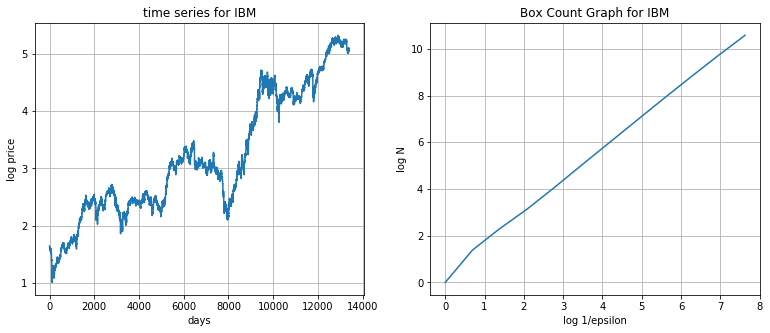

In [11]:
ticker='IBM'
N,dim,covers,L=analyze_stock(ticker)
assert 1.1390537589837473 <= dim <= 1.541072732742717 

### Plot graph with boxes
This portion of the code plots the stock price sequence and overlays it with the boxes that the sequence passes over. The ***covers*** dictionary returned by box_count is used to overlay the boxes. You can use the graphs generated to verify if you have identified the correct set of rectangles that pass through the sequence.

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
G=16
def plot_boxes(LL,covers):
    figure(figsize=[15,10])
    plot(LL)
    axes=gca()
    xmin=0.0; xmax=len(LL)-1.0
    ymin=min(LL)
    ymax=max(LL)
    yloc = plticker.MultipleLocator((ymax-ymin)/G)
    xloc = plticker.MultipleLocator((xmax-xmin)/G)
    axes.xaxis.set_major_locator(xloc)
    axes.yaxis.set_major_locator(yloc)

    # Add the grid
    axes.grid(which='major', axis='both', linestyle='-')
    
    colors='gbrygbrygbrygbry'
    for level in range(3,8):
        N = 2**level
        blocks=covers[N]

        for xmin,xmax,ymin,ymax in blocks:
            width=xmax-xmin
            height=ymax-ymin 
            axes.add_patch(
                patches.Rectangle(
                    (xmin, ymin),   # (x,y)
                    width,          # width
                    height,          # height
                    alpha=0.2,color=colors[level]
                ))

{1: [(0, 4496, 0.3412228393798106, 6.011210474527809)], 2: [(0, 2248, 0.3412228393798106, 6.011210474527809), (2248, 4496, 3.17621665695381, 6.011210474527809)], 4: [(0, 1124, 0.3412228393798106, 6.011210474527809), (1124, 2248, 1.7587197481668104, 4.59371356574081), (2248, 3372, 3.17621665695381, 6.011210474527809), (3372, 4496, 4.59371356574081, 6.011210474527809)], 8: [(0, 562, 0.3412228393798106, 5.30246202013431), (562, 1124, 1.7587197481668104, 5.30246202013431), (1124, 1686, 1.7587197481668104, 4.59371356574081), (1686, 2248, 3.17621665695381, 4.59371356574081), (2248, 2810, 3.17621665695381, 4.59371356574081), (2810, 3372, 3.17621665695381, 5.30246202013431), (3372, 3934, 4.59371356574081, 6.011210474527809), (3934, 4496, 5.30246202013431, 6.011210474527809)], 16: [(0, 281, 0.3412228393798106, 2.82184242975706), (281, 562, 2.46746820256031, 4.948087792937558), (562, 843, 3.1762166569538097, 4.948087792937558), (843, 1124, 1.7587197481668102, 3.8849651113473094), (1124, 1405, 1.

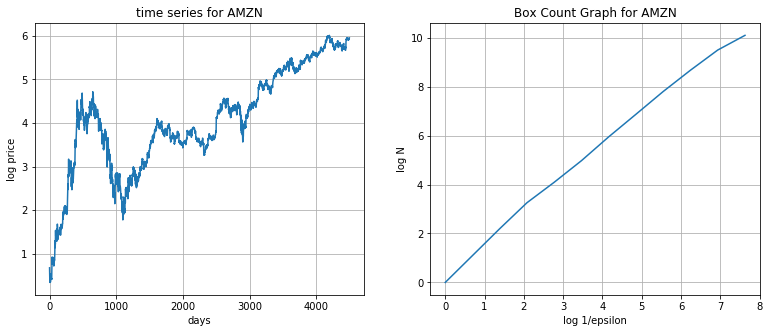

In [14]:
ticker='AMZN'
N,dim,covers,L=analyze_stock(ticker)
assert 1.049035790021836 <= dim <= 1.4192837159118956

Text(0.5,1,'box plot for AMZN')

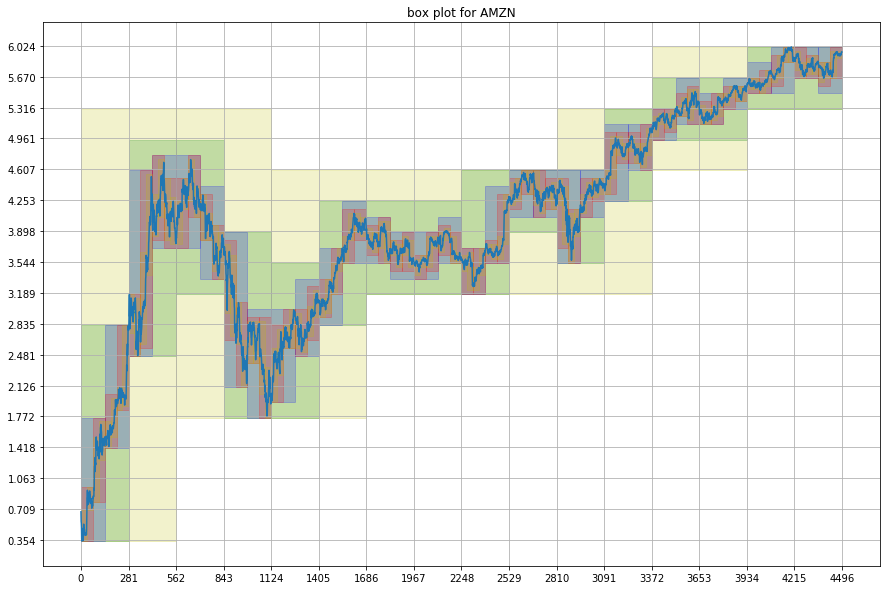

In [15]:
LL=log(L)
plot_boxes(LL,covers)
title('box plot for '+ticker)



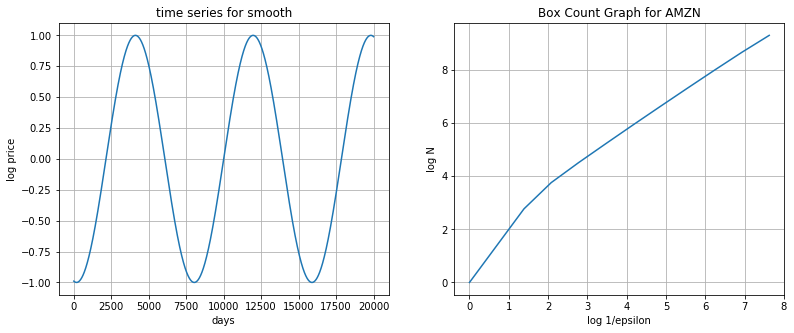

In [16]:
x=arange(-1,1,0.0001)
y=exp(sin(8*x))
N,dim,covers=analyze_sequence(y,'smooth')

assert 0.842026014152719 <= dim <= 1.1392116662066198

Text(0.5,1,'box plot for smooth')

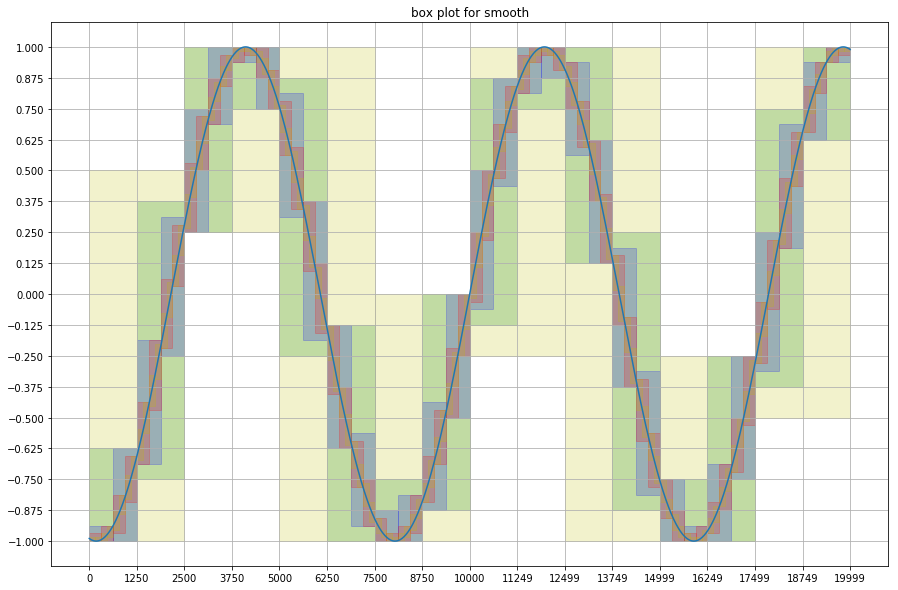

In [17]:
LL=log(y)
plot_boxes(LL,covers)
title('box plot for '+'smooth')

In [18]:
# Hidden tests

In [19]:
# Hidden tests

In [20]:
# Hidden tests

In [21]:
# Hidden tests